# Carga de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = pd.read_csv("DelayedFlights.csv") # carga de datos
data.drop(["Unnamed: 0"], axis=1, inplace=True)


#Limpieza de datos
data.drop_duplicates(subset=["FlightNum", "Year", "Month", "DayofMonth", "CRSDepTime", "Origin", "Dest", "UniqueCarrier"], inplace=True)
data = data[
    (data["Cancelled"] == 0)
    & ~(data["ArrTime"].isnull())
    & ~(data["DepTime"].isnull())
    & (data["CRSElapsedTime"]>0)
    & ~(data["ArrDelay"].isnull())
    & ~(data["DepDelay"].isnull())
    ]
data.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


# Definición de nuevas columnas

In [13]:
# Atrasos de 10, 20 y 30 minutos
data["ArrDelay10"] = data["ArrDelay"].apply(lambda s: 1 if s>=10 else 0)
data["DepDelay10"] = data["DepDelay"].apply(lambda s: 1 if s>=10 else 0)
data["ArrDelay20"] = data["ArrDelay"].apply(lambda s: 1 if s>=20 else 0)
data["DepDelay20"] = data["DepDelay"].apply(lambda s: 1 if s>=20 else 0)
data["ArrDelay30"] = data["ArrDelay"].apply(lambda s: 1 if s>=30 else 0)
data["DepDelay30"] = data["DepDelay"].apply(lambda s: 1 if s>=30 else 0)

def bloque_horario4(time):
    if time>=0 and time<=600:
        return "Madrugada"
    elif time>600 and time<=1200:
        return "Mañana"
    elif time>1200 and time<=2000:
        return "Tarde"
    else:
        return "Noche"

data["DepHourBlock4"] = data["DepTime"].apply(bloque_horario4)
data["ArrHourBlock4"] = data["ArrTime"].apply(bloque_horario4)
data["DepHourBlock2"] = data["DepTime"].apply(lambda s: "AM" if s<=1200 else "PM")
data["ArrHourBlock2"] = data["ArrTime"].apply(lambda s: "AM" if s<=1200 else "PM")

# Visualizaciones de atrasos por proporciones

In [50]:
def delay_proportion_plot(data: pd.DataFrame, group_by_col: str, minutes: str):

    data_agg = data.groupby(by=[group_by_col]).apply(lambda s: pd.Series({
        "Cantidad de vuelos": len(s), 
        "Cantidad de atrasos en departure": len(s[s[f"DepDelay{minutes}"]==1]), 
        "Cantidad de atrasos en arrival": len(s[s[f"ArrDelay{minutes}"]==1]),
        "Proporción de atrasos en departure": len(s[s[f"DepDelay{minutes}"]==1])/len(s), 
        "Proporción de atrasos en arrival": len(s[s[f"ArrDelay{minutes}"]==1])/len(s)
    }), include_groups=False)
    data_agg.reset_index(inplace=True)
    data_agg.sort_values(by=["Proporción de atrasos en departure"], inplace=True, ascending=True)

    _, ax1 = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
    ax1[0].bar(data_agg[group_by_col], data_agg["Cantidad de vuelos"], color = "r", label = "Total de vuelos")
    ax1[0].bar(data_agg[group_by_col], data_agg["Cantidad de atrasos en departure"], color = "b", label = "Cantidad de atrasos")
    ax1[0].set_ylabel("Número de atrasos")
    ax1[0].set_xlabel("Bloque horario")
    ax1[0].set_title(f"Delays departure > {minutes} minutos")

    ax2 = ax1[0].twinx()
    ax2.plot(data_agg[group_by_col], data_agg["Proporción de atrasos en departure"], color="black", marker="*", label = "Proporción de atrasos")
    ax2.set_ylabel("Proporción de atrasos")
    lines1, labels1 = ax1[0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc = "upper left")

    ax1[1].bar(data_agg[group_by_col], data_agg["Cantidad de vuelos"], color = "r", label = "Total de vuelos")
    ax1[1].bar(data_agg[group_by_col], data_agg["Cantidad de atrasos en arrival"], color = "b", label = "Cantidad de atrasos")
    ax1[1].set_ylabel("Número de atrasos")
    ax1[1].set_xlabel("Bloque horario")
    ax1[1].set_title(f"Delays departure > {minutes} minutos")

    ax2 = ax1[1].twinx()
    ax2.plot(data_agg[group_by_col], data_agg["Proporción de atrasos en arrival"], color="black", marker="*", label = "Proporción de atrasos")
    ax2.set_ylabel("Proporción de atrasos")
    lines1, labels1 = ax1[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc = "upper left")
    plt.tight_layout()


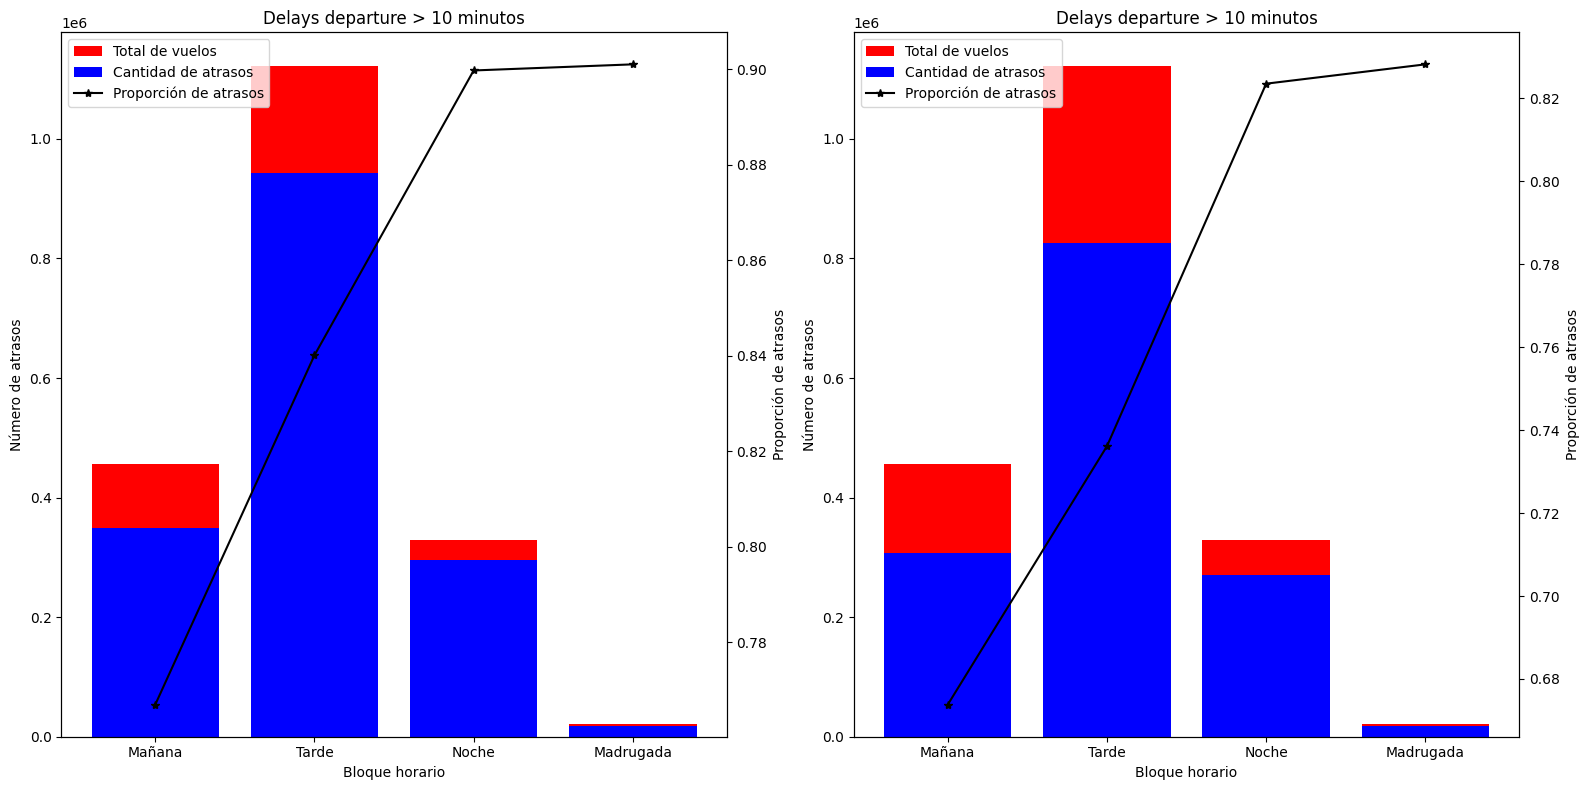

In [52]:
delay_proportion_plot(data, "DepHourBlock4", 10)

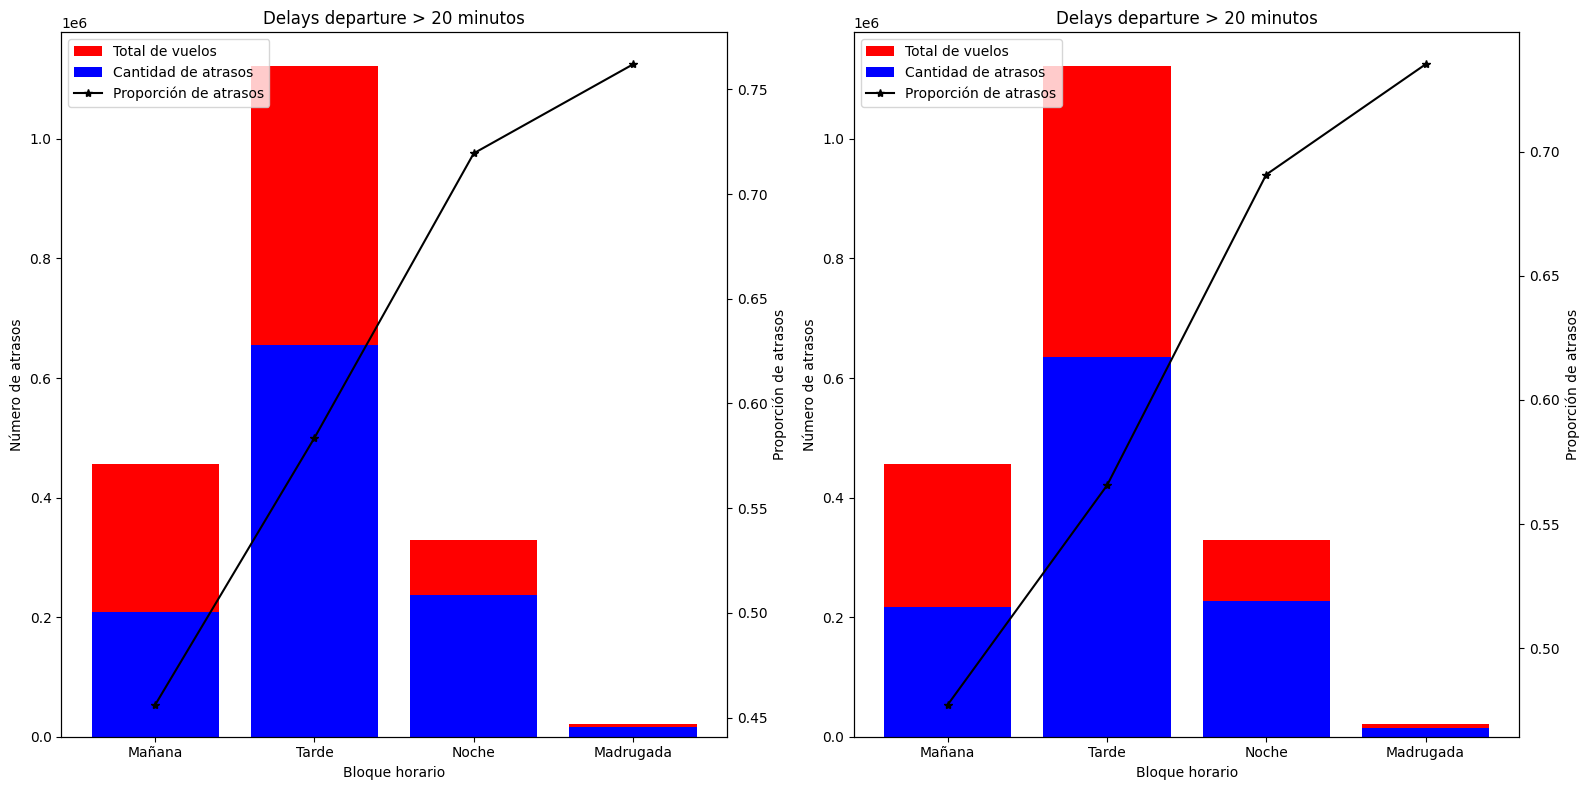

In [53]:
delay_proportion_plot(data, "DepHourBlock4", 20)

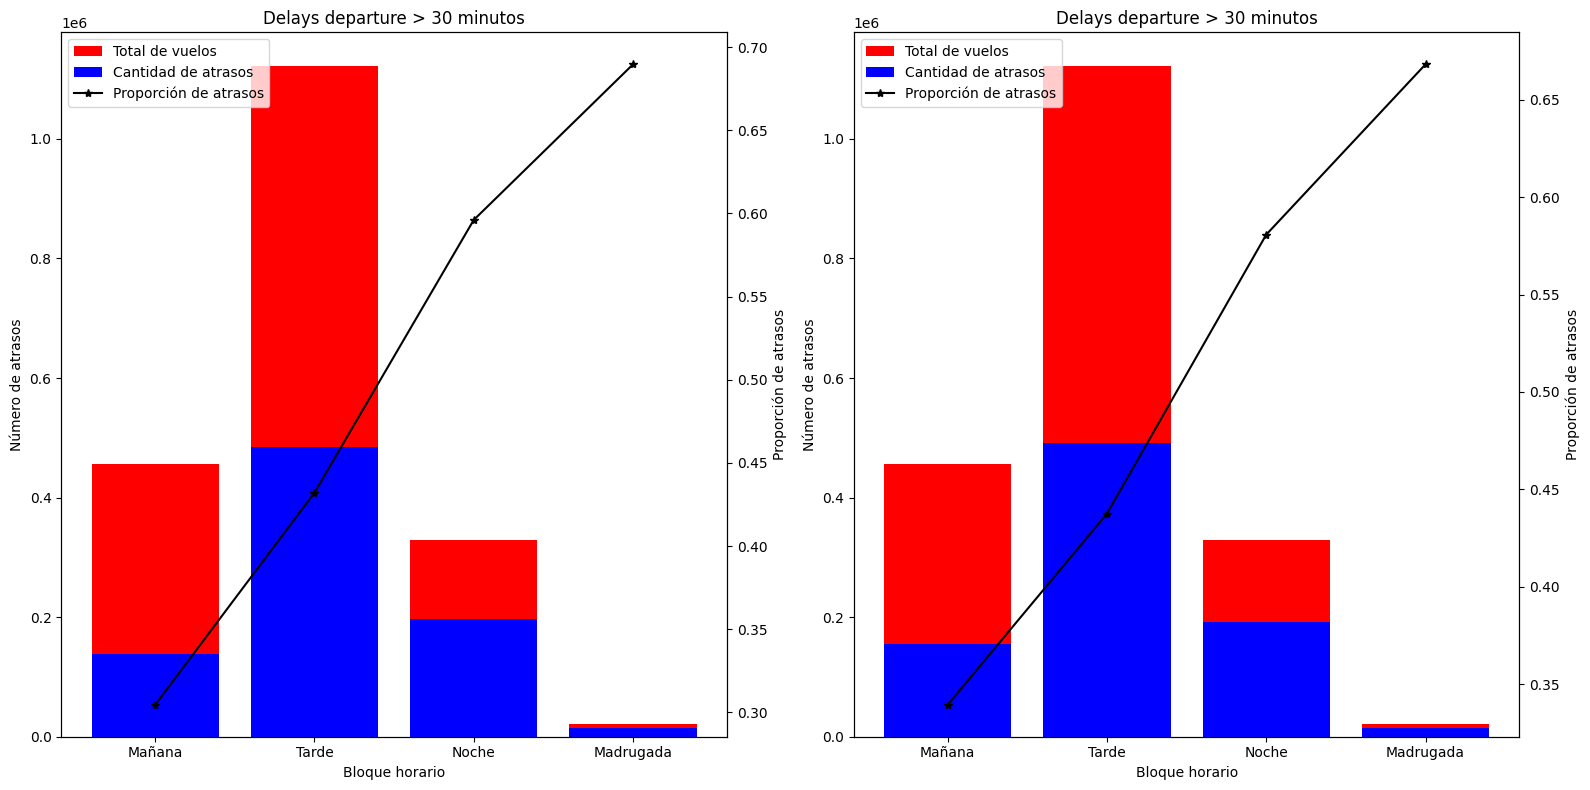

In [54]:
delay_proportion_plot(data, "DepHourBlock4", 30)